<a href="https://colab.research.google.com/github/jdy5294/All_Deep_Learning/blob/main/Code/CH18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 18장 시퀀스 배열로 다루는 순환 신경망(RNN)

## 1. LSTM을 이용한 로이터 뉴스 카테고리 분류하기

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.datasets import reuters       # 로이터 뉴스 데이터셋 불러오기
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)    # num_words=1000: 빈도가 1~1000에 해당하는 단어만 선택해서 불러오기

category = np.max(y_train) + 1
print(category, '카테고리')
print(len(X_train), '학습용 뉴스 기사')
print(len(X_test), '테스트용 뉴스 기사')
print(X_train[0])                       # tokenizer() 작업을 마친 데이터이므로 빈도수에 해당하는 숫자들이 나옴
print(y_train[0])

46 카테고리
8982 학습용 뉴스 기사
2246 테스트용 뉴스 기사
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
3


In [ ]:
for i in range(10):
  print(len(X_train[i]))    # 기사마다 단어의 수가 다르므로 맞춰야 함

X_train = sequence.pad_sequences(X_train, maxlen=100)     # 단어 수를 100개로 맞춤 (넘으면 100개까지만 선택하고 나머지는 버림, 모자라면 0으로 채움)
X_test = sequence.pad_sequences(X_test, maxlen=100)

y_train = to_categorical(y_train)     # 원-핫 인코딩
y_test = to_categorical(y_test)

87
56
139
224
101
116
100
100
82
106


In [ ]:
model = Sequential()
model.add(Embedding(1000, 100))             # Embedding('불러온 단어의 총수', '기사당 단어 수')
model.add(LSTM(100, activation='tanh'))     # LSTM(기사당 단어 수): RNN에서 기억 값에 대한 가중치 제어
model.add(Dense(46, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         100000    
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 46)                4646      
                                                                 
Total params: 185046 (722.84 KB)
Trainable params: 185046 (722.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# history = model.fit(X_train, y_train, batch_size=20, epochs=200, validation_data=(X_test, y_test), callbacks=[early_stopping_callback])
history = model.fit(X_train, y_train, batch_size=20, epochs=200, validation_split=0.25, callbacks=[early_stopping_callback])

print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/200
337/337 [==============================] - 29s 80ms/step - loss: 2.2563 - accuracy: 0.4200 - val_loss: 2.0638 - val_accuracy: 0.4902
Epoch 2/200
337/337 [==============================] - 26s 78ms/step - loss: 1.8496 - accuracy: 0.5229 - val_loss: 1.7110 - val_accuracy: 0.5432
Epoch 3/200
337/337 [==============================] - 29s 85ms/step - loss: 1.6872 - accuracy: 0.5621 - val_loss: 1.6205 - val_accuracy: 0.5859
Epoch 4/200
337/337 [==============================] - 26s 79ms/step - loss: 1.5699 - accuracy: 0.5944 - val_loss: 1.5996 - val_accuracy: 0.5837
Epoch 5/200
337/337 [==============================] - 26s 78ms/step - loss: 1.4492 - accuracy: 0.6262 - val_loss: 1.5394 - val_accuracy: 0.6131
Epoch 6/200
337/337 [==============================] - 26s 76ms/step - loss: 1.3363 - accuracy: 0.6575 - val_loss: 1.4058 - val_accuracy: 0.6558
Epoch 7/200
337/337 [==============================] - 26s 78ms/step - loss: 1.2391 - accuracy: 0.6825 - val_loss: 1.3278 - val_ac

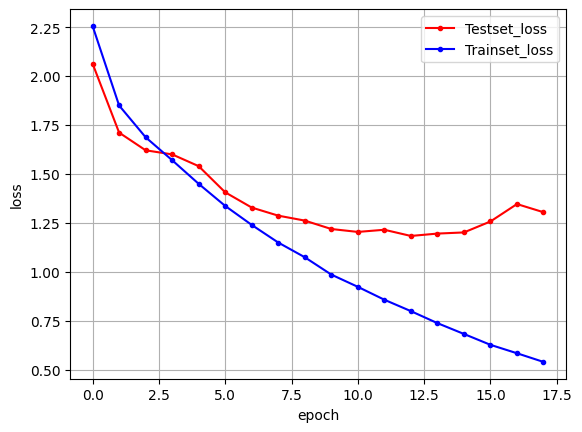

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 2. LSTM과 CNN의 조합을 이용한 영화 리뷰 분류하기

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

model = Sequential()
model.add(Embedding(5000, 100))
model.add(Dropout(0.5))
model.add(Conv1D(64, 5, padding='valid', activation='relu', strides=1))    # Conv2D를 1차원으로 변형시킨 함수 (커널 수 64개, 필터 크기 5)
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(55))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

17464789/17464789 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         500000    
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 64)          32064     
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 64)          0         
 D)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 55)                26400     
                                                                 
 dense_1 (Dense)             (None, 1)                 

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(X_train, y_train, batch_size=40, epochs=100, validation_split=0.25, callbacks=[early_stopping_callback])

print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/100
469/469 [==============================] - 103s 214ms/step - loss: 0.4184 - accuracy: 0.7906 - val_loss: 0.2835 - val_accuracy: 0.8882
Epoch 2/100
469/469 [==============================] - 93s 198ms/step - loss: 0.2372 - accuracy: 0.9070 - val_loss: 0.2625 - val_accuracy: 0.8942
Epoch 3/100
469/469 [==============================] - 96s 205ms/step - loss: 0.1908 - accuracy: 0.9286 - val_loss: 0.2601 - val_accuracy: 0.8930
Epoch 4/100
469/469 [==============================] - 96s 206ms/step - loss: 0.1498 - accuracy: 0.9452 - val_loss: 0.2849 - val_accuracy: 0.8904
Epoch 5/100
469/469 [==============================] - 97s 207ms/step - loss: 0.1233 - accuracy: 0.9569 - val_loss: 0.3003 - val_accuracy: 0.8930
Epoch 6/100
782/782 [==============================] - 30s 38ms/step - loss: 0.3561 - accuracy: 0.8763

 Test Accuracy: 0.8763


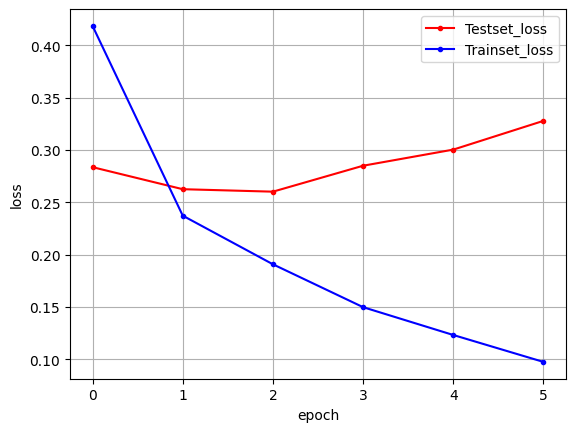

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 3. 어텐션을 사용한 신경망

- **RNN**: 마지막 셀에 담긴 값에 전체 문장의 뜻이 함축 (context vector)
- **Attention**: 어텐션 가중치를 이용해 매 출력마다 모든 입력 값을 두루 활용하게 함

In [ ]:
!pip install attention

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from attention import Attention

import numpy as np
import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

model = Sequential()
model.add(Embedding(5000, 500))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(Attention())
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(X_train, y_train, batch_size=40, epochs=100,  validation_data=(X_test, y_test), callbacks=[early_stopping_callback])

print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/100
625/625 [==============================] - ETA: 0s - loss: 0.3869 - accuracy: 0.8219

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()